<a href="https://colab.research.google.com/github/julianopcardoso/cnnbridgedamagedetection/blob/main/Projeto_final_Prepara%C3%A7%C3%A3o_do_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Disciplina: Aprendizado Profundo 02/2023**

Professor:
Anderson Rocha Tavares

Grupo:
Daniele Kauctz,
Gabriel Beretta,
Juliano Cardoso

<br>

---

## Detecção de danos estruturais em pontes através de Rede Neurais Artificiais





Identificar possíveis danos estruturais em pontes através de análise de sensores de aceleração utilizando séries temporais.

Esses sensores de aceleração (acelerômetros) são capazes de identificar vibrações em qualquer estrutura. Essas vibrações ocorrem de acordo com as características do sistema sendo uma propriedade sensível ao dano.

Os dados de entrada são valores de aceleração (m/s²) ao longo do tempo no cenários íntegros e danificados.

<br>

Dataset: Old_ADA_Bridge-damage_vibration_data

Related work: Ambient and Vehicle-Induced Vibration Data of a Steel Truss Bridge Subject to Artificial Damage



## Importação das bibliotecas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
from matplotlib.backends.backend_agg import FigureCanvasAgg
import os
import random
import shutil
drive.mount('/content/drive', force_remount=True) # Não esquecer de ajustas os PATHS

Mounted at /content/drive


In [ ]:
# Plotagem
! sudo apt-get update
! sudo apt-get install texlive-latex-recommended
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended
! wget http://mirrors.ctan.org/macros/latex/...
! unzip type1cm.zip -d /tmp/type1cm
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm
! sudo texhash
!apt install cm-super

import matplotlib
from matplotlib import rc
rc('font',**{'family':'Times New Roman','size' :12})
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rc('text', usetex=True)
matplotlib.rc('axes', labelsize=12)
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)
matplotlib.rc('lines', lw=1.0,color='k')
matplotlib.rc('axes',lw=0.75)
matplotlib.rc('legend', fontsize=10)

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [665 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,398 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1,685 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,061 kB]
Hit:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:13 https://p

## Importação dos dados experimentais

In [ ]:
def read_files(tipo):
  df_all = []

  entries = os.listdir('/content/drive/<PATH_TO_FILES>')
  list = [x for x in entries if x.find(tipo) >  0]

  for arquivo in list:
    df = pd.read_csv(f'/content/drive/<PATH_TO_FILES>/{arquivo}',delim_whitespace=True, header = None,dtype = 'float')

    if df.shape[1] == 12:
      for _ in range(3):
        df = df.drop(df.columns[-1], axis=1)

    df = df.drop(df.columns[0], axis=1)

    for i in range(0,len(df),1000):
      if len(df[i:i+1000]) == 1000:
        df_all.append(df[i:i+1000])
  return df_all

In [ ]:
df_dmg = read_files('DMG')
df_int = read_files('INT')
df_rcv = read_files('RCV')
len(df_dmg), len(df_int), len(df_rcv)

(489, 436, 175)

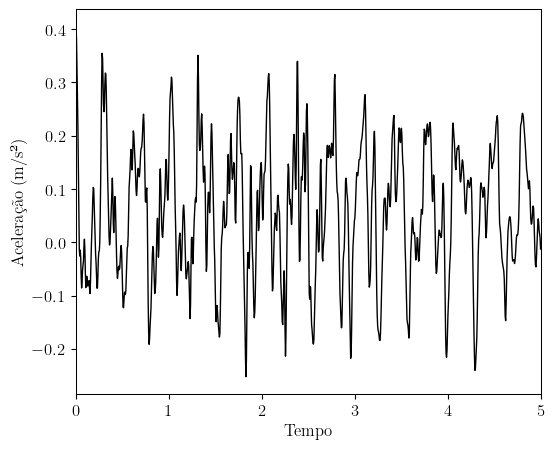

In [ ]:
n = 1000             # pontos no tempo
sf = 200             # frequência de aquisição [Hz] - dado em Kim et al. (2021)
tf = n/sf            # tempo total de cada sinal
plt.figure(1,figsize=(6,5))
plt.plot(np.linspace(0,tf,n),      df_dmg[10][7][:n], 'k')
plt.xlabel('Tempo')
plt.ylabel('Aceleração (m/s²)')
plt.xlim([0,5]);

## Preparação do dataset dos dados experimentais

In [ ]:
# Transformada Rápida de Fourier
def fast_fourier_transform(x,dof,n):
  freq_spec_all = np.zeros((len(x),int((n/2)+1),dof))   # shape = (número de dados, metade do tamanho da série temporal + 1, número de sensores)

  for i in range(len(x)):
    mean = np.mean(x[i], axis=0)         # média dos sinais

    aux = np.zeros((n,dof))

    for q in range(dof):
      aux[:,q] = x[i][q+1] - mean[q+1]   # tirando a média dos sinais (possíveis ruídos)

    freq_spec = np.fft.rfft(aux, axis=0) # single-sided spectrum
    freq_spec = abs(freq_spec)
    freq_spec_all[i,:,:] = freq_spec

  return freq_spec_all

In [ ]:
dof = 7                   # número de sensores
n = 1000                  # pontos no tempo
sf = 200                  # frequência de aquisição [Hz] - dado em Kim et al. (2021)
tf = n/sf                 # tempo total de cada sinal
m = int(n/2 +  1)         # número de pontos do espectro de cada sinal
f_ultima = (n/tf)/2       # último valor de frequência do espectro = 100 Hz


freq_spec_dmg = fast_fourier_transform(df_dmg,dof,n)
freq_spec_int = fast_fourier_transform(df_int,dof,n)
freq_spec_rcv = fast_fourier_transform(df_rcv,dof,n)

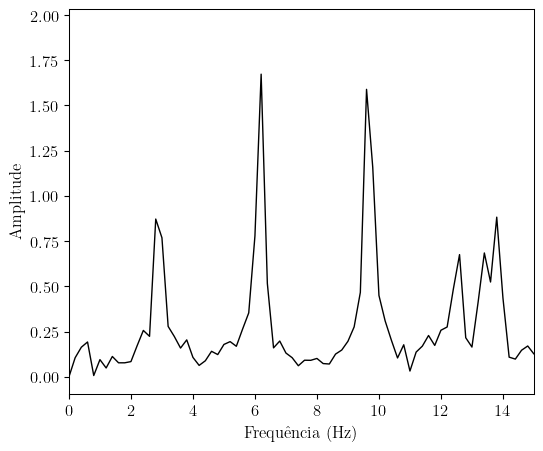

In [ ]:
# Exemplo do espectro de potência (intensidade de cada frequência no sinal de aceleração analisado)
f = np.linspace(0,f_ultima,m)  # pontos de frequência

plt.figure(2,figsize=(6,5))
plt.plot(f, freq_spec_dmg[50,:,1], 'k')
plt.xlim([0,15])               # 5 primeiras frequências da estrutura estão abaixo de 15 Hz
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude')
plt.xlim([0,15])
plt.savefig('Exemplo_fft.pdf')

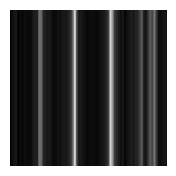

In [ ]:
# Exemplo de imagem de grades sinusoidais
X, Y = np.meshgrid(freq_spec_dmg[50,:,1], freq_spec_dmg[50,:,1])    # lista de matriz de coordenadas da FFT

wavelength = 200        # comprimento de onda: distância entre um pico e o próximo da onda
angle = 0               # ângulo de rotação das grades sinusoidais

grating = np.sin(2*np.pi*(X*np.cos(angle) + Y*np.sin(angle)) / wavelength)   # gradação da imagem
fig = plt.figure(frameon=False,facecolor="w", figsize=(1.5, 1.5))
ax = fig.add_subplot()

ax.set_xlim([0, 75])                 # limite de pontos para frequência de 15 Hz
ax.set_ylim([0, 75])                 # limite de pontos para frequência de 15 Hz
ax.set_axis_off()

plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.margins(0,0)

img = ax.imshow(grating, cmap="gray")
plt.savefig('Exemplo.pdf')
plt.show()

## Criação do dataset

In [ ]:
def dataset_images(spectro, diretorio, classe):
  for i in range(len(spectro)):
    for j in range(7):

      # Teste de imagens de grades sinusoidais
      X, Y = np.meshgrid(spectro[i,:,j], spectro[i,:,j])    # lista de matriz de coordenadas da FFT

      wavelength = 200        # comprimento de onda: distância entre um pico e o próximo da onda
      angle = 0               # ângulo de rotação das grades sinusoidais

      plt.ioff()
      grating = np.sin(2*np.pi*(X*np.cos(angle) + Y*np.sin(angle)) / wavelength)   # gradação da imagem
      fig = plt.figure(frameon=False,facecolor="w", figsize=(1.5, 1.5))
      ax = fig.add_subplot()

      ax.set_xlim([0, 75])                 # limite de pontos para frequência de 15 Hz
      ax.set_ylim([0, 75])                 # limite de pontos para frequência de 15 Hz
      ax.set_axis_off()

      plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
      plt.margins(0,0)

      img = ax.imshow(grating, cmap="gray")

      # Convertendo plot para array
      fig_canvas_agg = FigureCanvasAgg(fig)
      fig_canvas_agg.draw()
      img_rgba = np.array(fig_canvas_agg.renderer.buffer_rgba())

      plt.imsave(f'/content/drive/<PATH_TO_IMAGES>/imagens/{diretorio}/image_{classe}_{i}_{j}.png',img_rgba, cmap="gray")


In [ ]:
freq_spec_int.shape

(436, 501, 7)

In [ ]:
freq_spec_rcv.shape

(175, 501, 7)

In [ ]:
freq_spec_dmg.shape

(489, 501, 7)

In [ ]:
dataset_images(freq_spec_dmg, 'dmg','dmg')
dataset_images(freq_spec_int, 'int', 'int')
dataset_images(freq_spec_rcv, 'int', 'rcv')

<ipython-input-10-4c7b6dce4940>:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(frameon=False,facecolor="w", figsize=(1.5625 , 1.5625))


In [ ]:
from glob import glob #importa biblioteca para trabalhar com os diretórios das imagens
len(glob(f'/content/drive/<PATH_TO_IMAGES>/imagens/dmg/*'))

3423

In [ ]:
from glob import glob #importa biblioteca para trabalhar com os diretórios das imagens
len(glob(f'/content/drive/<PATH_TO_IMAGES>/imagens/int/*'))

4277

In [ ]:
# Com dano 3.423
# Sem dano 4.277
# train
print(f'Treinamento - Dano: {3423*0.75}')
print(f'Treinamento - Sem dano: {4277*0.75}')
# val
print(f'Validação - Dano: {3423*0.20}')
print(f'Validação - Sem dano: {4277*0.20}')
# tes
print(f'Teste - Dano: {3423*0.05}')
print(f'Teste - Sem dano: {4277*0.05}')

Treinamento - Dano: 2567.25
Treinamento - Sem dano: 3207.75
Validação - Dano: 684.6
Validação - Sem dano: 855.4000000000001
Teste - Dano: 171.15
Teste - Sem dano: 213.85000000000002


In [ ]:
def mover_arquivos(origem, destino, percentual):
  # Diretórios de origem e destino
  diretorio_origem = origem
  diretorio_destino = destino

  # Lista todos os arquivos no diretório de origem
  arquivos = os.listdir(diretorio_origem)

  # Calcula a quantidade de arquivos a serem movidos
  quantidade_a_mover = int(percentual)

  # Seleciona aleatoriamente os arquivos a serem movidos
  arquivos_a_mover = random.sample(arquivos, quantidade_a_mover)

  # Move os arquivos para o diretório de destino
  for arquivo in arquivos_a_mover:
      caminho_origem = os.path.join(diretorio_origem, arquivo)
      caminho_destino = os.path.join(diretorio_destino, arquivo)
      shutil.move(caminho_origem, caminho_destino)

In [ ]:
suf_path = '/content/drive/<PATH_TO_IMAGES>/imagens'

In [ ]:
# Caminho dmg
origem_dmg = f'{suf_path}/dmg'
# Caminho int
origem_int = f'{suf_path}/int'

In [ ]:
# 75%
percentual_dmg = .75 * 3423
percentual_int = .75 * 4277
# Treinamento - Dano:
destino = f'{suf_path}/train/dmg'
mover_arquivos(origem_dmg, destino, percentual_dmg)
# Treinamento - Sem dano:
destino = f'{suf_path}/train/int'
mover_arquivos(origem_int, destino, percentual_int)

# 20%
percentual_dmg = .20 * 3423
percentual_int = .20 * 4277
# Validação - Dano:
destino = f'{suf_path}/val/dmg'
mover_arquivos(origem_dmg, destino, percentual_dmg)
# Validação - Sem dano:
destino = f'{suf_path}/val/int'
mover_arquivos(origem_int, destino, percentual_int)

# 5%
percentual_dmg = .05 * 3423
percentual_int = .05 * 4277
# Teste - Dano:
destino =  f'{suf_path}/test/dmg'
mover_arquivos(origem_dmg, destino, percentual_dmg)
# Teste - Sem dano:
destino =  f'{suf_path}/test/int'
mover_arquivos(origem_int, destino, percentual_int)

Treinamento - Dano: 2567.25

Treinamento - Sem dano: 3207.75

Validação - Dano: 684.6

Validação - Sem dano: 855.4000000000001

Teste - Dano: 171.15

Teste - Sem dano: 213.85000000000002

In [ ]:
from glob import glob #importa biblioteca para trabalhar com os diretórios das imagens
print(f'Treinamento - Com Dano: {len(glob("/content/drive/<PATH_TO_IMAGES>/imagens/train/dmg/*"))}')
print(f'Treinamento - Sem Dano: {len(glob("/content/drive/<PATH_TO_IMAGES>/imagens/train/int/*"))}')
print(f'Validação - Com Dano: {len(glob("/content/drive/<PATH_TO_IMAGES>/imagens/val/dmg/*"))}')
print(f'Validação - Sem Dano: {len(glob("/content/drive/<PATH_TO_IMAGES>/imagens/val/int/*"))}')
print(f'Teste - Com Dano: {len(glob("/content/drive/<PATH_TO_IMAGES>/imagens/test/dmg/*"))}')
print(f'Teste - Sem Dano: {len(glob("/content/drive/<PATH_TO_IMAGES>/imagens/test/int/*"))}')

Treinamento - Com Dano: 2567
Treinamento - Sem Dano: 3208
Validação - Com Dano: 685
Validação - Sem Dano: 855
Teste - Com Dano: 171
Teste - Sem Dano: 213
